In [ ]:
import nibabel as nib
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from skimage.transform import rotate
from skimage.util import montage
import os
from sklearn.model_selection import train_test_split
import keras
import cv2
import tensorflow
import random
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import numpy as np
from keras.callbacks import CSVLogger
import keras.backend as K
import zipfile
import pandas as pd



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import files

# This will prompt you to upload the kaggle.json file
uploaded = files.upload()


In [ ]:
zip_file_path = '/content/drive/My Drive/Colab Notebooks/BraTS2020_TrainingData.zip'

In [ ]:
import os
import zipfile

# Define the extraction path
extraction_path = '/content/BraTS2020_TrainingData'

# Create the extraction directory if it doesn't exist
os.makedirs(extraction_path, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

print("Extraction completed")


Extraction completed


# Données

Le jeu de données choisi est celui de la segmentation des tumeurs cérébrales (BraTS2020), disponible sur : [Kaggle - BraTS2020 Training Data](https://www.kaggle.com/datasets/awsaf49/brats2020-training-data). Ce jeu de données contient des scans multimodaux pour la segmentation des tumeurs cérébrales, qui sont au format de fichier NIfTI (.nii.gz). Ces scans décrivent différents volumes tels que :

- **T1 natif (T1)** : Images de résonance magnétique utilisées pour visualiser la structure de base du cerveau.
- **T1 post-contraste pondérée (T1Gd)** : Images T1 avec injection de Gadolinium, utilisées pour mettre en évidence les régions pathologiques qui accumulent le contraste.
- **T2 pondérée (T2)** : Images fournissant des détails sur la teneur en eau des tissus cérébraux, utiles pour détecter l'œdème et les infiltrations.
- **T2 Fluid Attenuated Inversion Recovery (T2-FLAIR)** : Images conçues pour supprimer le signal du liquide cérébrospinal, améliorant ainsi la visibilité des lésions inflammatoires et des anomalies.

Les annotations de tumeur comprennent :
- **Noyau tumoral nécrotique et non rehaussant (NCR/NET — étiquette 1)** : Partie centrale de la tumeur qui ne rehausse pas après injection de contraste et/ou qui est nécrotique.
- **Œdème péritumoral (ED — étiquette 2)** : Tissu inflammatoire ou œdémateux autour de la tumeur, souvent visible dans des images pondérées en T2.
- **Tumeur rehaussée par le Gadolinium (ET — étiquette 4)** : Région active de la tumeur qui accumule le contraste, indiquant souvent une tumeur
n des tumeurs cérébrales.


## Format des images
Les images sonttd ces sca, ces derniersns sont des fichiers NIfTI (Neuroimaging Informatics Technology Initiative). Une image NIfTI est une représentation numérique d'un objet tridimensionnel, comme un cerveau dans notre cas. Pour mieux comprendre cela, affichons la forme (shape) d'un scan de modalité ainsi que celle d'une segmentation (elles sont identiques dans ce jeu de données) :

### Exploration du format NIfTI

Les fichiers NIfTI sont couramment utilisés dans le domaine de l'imagerie médicale neurologique car ils supportent les données en trois dimensions et permettent de stocker plusieurs types de données, telles que l'intensité des pixels, dans un seul fichier compact. Cela facilite non seulement le stockage et la manipulation de grands volumes de données d'imagerie, mais aussi l'intégration de ces données dans divers outils d'analyse et de visualisation médicale.

Pour examiner la structure de ces données, nous pouvons utiliser des bibliothèques Python telles que `nibabel`, qui est spécialement conçue pour manipuler des fichiersé:", scan_data.shape)


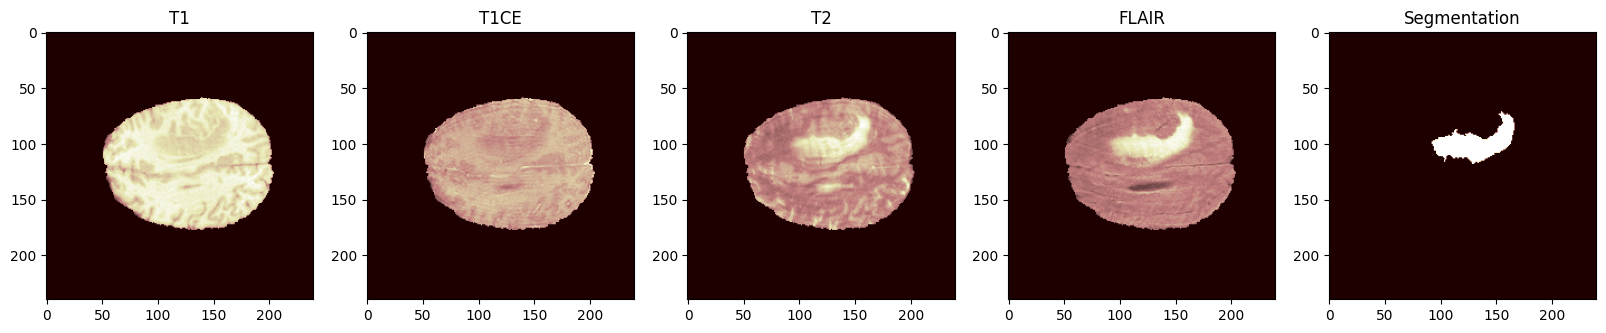

In [ ]:
# on prend le premier patient
sample_path = '/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_'


# Charger les 4 modalités IRM et la segmentation situées dans le parcours du patient à l'aide de la bibliothèque nibabel
t1_img=nib.load(sample_path + 't1.nii')
t1ce_img=nib.load(sample_path + 't1ce.nii')
t2_img=nib.load(sample_path + 't2.nii')
flair_img=nib.load(sample_path + 'flair.nii')
seg_img=nib.load(sample_path + 'seg.nii')


t1_data = t1_img.get_fdata()
t1ce_data = t1ce_img.get_fdata()
t2_data = t2_img.get_fdata()
flair_data = flair_img.get_fdata()
seg_data = seg_img.get_fdata()

# On plote une des slice avec les 4 modalités
slice_nb = 100

fig, axs = plt.subplots(1, 5, figsize=(20,20))
axs[0].imshow(t1_data[:,:,slice_nb], cmap="pink")
axs[0].set_title('T1')
axs[1].imshow(t1ce_data[:,:,slice_nb], cmap="pink")
axs[1].set_title('T1CE')
axs[2].imshow(t2_data[:,:,slice_nb], cmap="pink")
axs[2].set_title('T2')
axs[3].imshow(flair_data[:,:,slice_nb], cmap="pink")
axs[3].set_title('FLAIR')
axs[4].imshow(seg_data[:,:,slice_nb], cmap="pink")
axs[4].set_title('Segmentation')
plt.show()

On observe les 4 modalité  liquide.

Pour un radiologue ou un neurologue, la combinaison de ces modalités est précieuse pour obtenir une compréhension exhaustive d'une tumeur, permettant de déterminer sa nature et d'orienter le plan thérapeutique. Cependant, dans le cadre de l'application des techniques d'intelligence artificielle pour la segmentation des images, la réduction du nombre de modalités utilisées peut être bénéfique.

En effet, bien que chaque modalité apporte ses propres informations, certaines peuvent être redondantes ou moins pertinentes pour un modèle de segmentation automatique. L'utilisation de la modalité T1ce en lieu et place de la T1 native permet de capitaliser sur le contraste accru apporté par l'agent de contraste. De plus, la modalité T2, bien que riche en informations, peut parfois introduire du bruit sous forme de signaux hydriques qui pourraient compliquer l'identification des véritables frontières de la tumeur. C'est pourquoi la séquence FLAIR, avec son excellente capacité à isoler les anomalies du tissu cérébral, est préférée pour notre modèle.

En optant pour un modèle simplifié utilisant uniquement les séquences T1ce et FLAIR, nous visons à optimiser les performances de notre algorithme de segmentation tout en réduisant la charge computationnelle et les besoins en mémoire, ce qui est un avantage non négligeable pour le traitement rapide de grands volumes de données dans les applications cliniques réelles.


In [ ]:
# Modality shape
print(t1_data.shape)

# Segmentation shape
print(seg_data.shape)

(240, 240, 155)
(240, 240, 155)


Les modalités et les segmentations ont trois dimensions. Chaque dimension est composée d'une série d'images bidimensionnelles, appelées coupes, qui contiennent toutes le même nombre de pixels et sont empilées pour créer cette représentation en 3D. C'est pourquoi nous avons affiché des images 2D juste au-dessus (mnous avons affiché la 100ème coupe d'une certaine dimension, en définissant `slice_nb = 100`).

Ces trois dimensions correspondent aux trois dimensions spatiales de l'image : la largeur, la hauteur et la profondeur. En imagerie médicale, elles sont nommées plans axial/transverse, coronal et sagittal, correspondant aux trois principales orientations du corps humain, et donc du cerveau humain.

### Compréhension des orientations dans l'imagerie médicale

Les plans de coupe en imagerie médicale sont définis comme suit :

- **Axial ou transverse** : Cette coupe passe horizontalement à travers le corps, offrant une vue de dessus qui montre les relations anatomiques et pathologiques dans le plan supérieur-inférieur.
- **Coronal** : Orienté verticalement de l'avant vers l'arrière, ce plan divise le corps en parties antérieure et postérieure, permettant de visualiser les structures dans le plan frontal.
- **Sagittal** : Également vertical mais coupant le corps en parties gauche et droite, le plan sagittal permet d'examiner les relations anatomiques dans le plan latéral.

Chacun de ces plans offre une perspective unique sur l'anatomie et les pathologies possibles, facilitant une compréhension complète et détaillée des structures internes, en particulier dans le contexte de la neurologie où le positionnement précis des structures cérébrales et des anomalies est crucial pour le diagnostic et la planification du traitement.


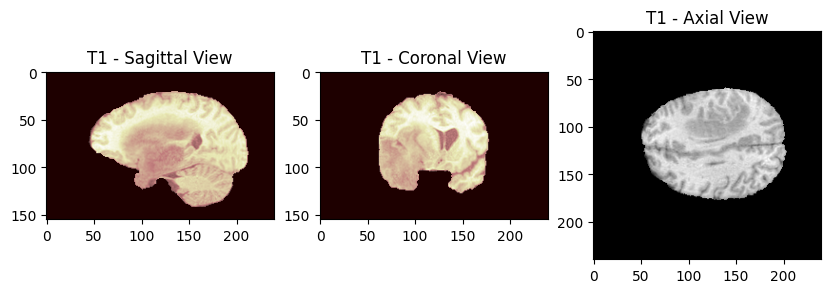

In [ ]:
# Plot a RMI modality through all planes
slice_nb = 100

fig, axs2 = plt.subplots(1, 3, figsize=(10,10))

# Apply a 90° rotation with an automatic resizing, otherwise the display is less obvious to analyze
axs2[0].imshow(rotate(t1_data[slice_nb,:,:], 90, resize=True), cmap="pink")
axs2[0].set_title('T1 - Sagittal View')

axs2[1].imshow(rotate(t1_data[:,slice_nb,:], 90, resize=True), cmap="pink")
axs2[1].set_title('T1 - Coronal View')

axs2[2].imshow(t1_data[:,:,slice_nb], cmap="gray")
axs2[2].set_title('T1 - Axial View')

plt.show()

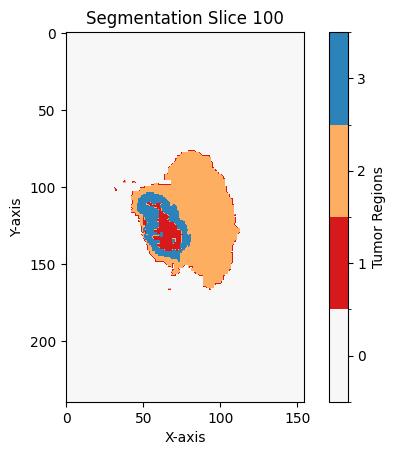

In [ ]:
# Load the segmentation data
seg_img_path = "/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_seg.nii"
some_seg_img = nib.load(seg_img_path).get_fdata()

# Create a custom color map with new, vivid colors
cmap = mpl.colors.ListedColormap(['#f7f7f7', '#d7191c', '#fdae61', '#2b83ba'])
norm = mpl.colors.BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5], cmap.N)

# Plot the 100th slice
slice_index = 100
plt.imshow(some_seg_img[slice_index, :, :], cmap=cmap, norm=norm)
plt.colorbar(ticks=[0, 1, 2, 3], label='Tumor Regions')
plt.title(f'Segmentation Slice {slice_index}')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# Display the plot
plt.show()


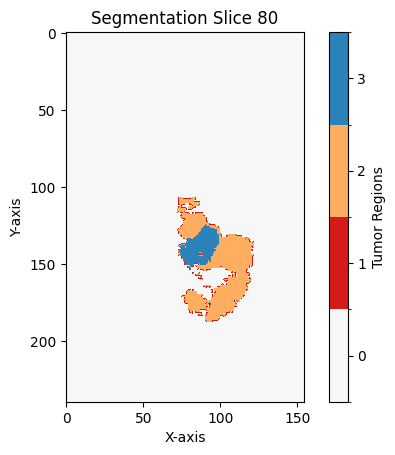

In [ ]:
# Load the segmentation data
seg_img_path_2 = "/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_010/BraTS20_Training_010_seg.nii"
some_seg_img_2 = nib.load(seg_img_path_2).get_fdata()

# Plot the 100th slice
slice_index = 80
plt.imshow(some_seg_img_2[slice_index, :, :], cmap=cmap, norm=norm)
plt.colorbar(ticks=[0, 1, 2, 3], label='Tumor Regions')
plt.title(f'Segmentation Slice {slice_index}')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# Display the plot
plt.show()

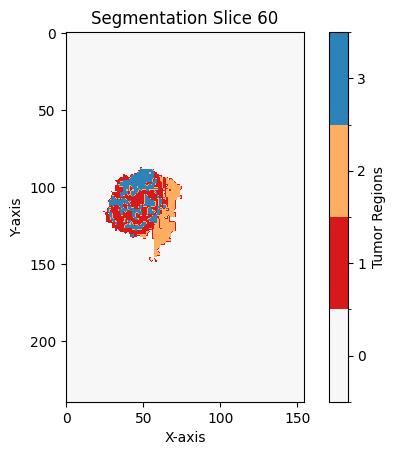

In [ ]:
# Load the segmentation data
seg_img_path_3 = "/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_020/BraTS20_Training_020_seg.nii"
some_seg_img_3 = nib.load(seg_img_path_3).get_fdata()

# Plot the 100th slice
slice_index = 60
plt.imshow(some_seg_img_3[slice_index, :, :], cmap=cmap, norm=norm)
plt.colorbar(ticks=[0, 1, 2, 3], label='Tumor Regions')
plt.title(f'Segmentation Slice {slice_index}')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# Display the plot
plt.show()

Quel que soit le plan qu'on visualise, on remarque que certaines tranches ont plusieurs couleurs ce qui signifie que les experts ont attribué plusieurs valeurs à la segmentation. Nous constatons que les fichiers de segmentation comportent quatre valeurs possibles, correspondant à quatre classes distinctes. Voici à quoi ces valeurs correspondent :

- **0 : Zone Saine ou Fond (NT)**, ce qui signifie qu'il n'y a pas de tumeur.
- **1 : Tumeur Nécrotique et Non-Rehaussante (NCR + NET)**, qui représente les zones de tumeur nécrosées ou non améliorées par le contraste.
- **2 : Œdème Péritumoral (ED)**, indiquant les zones de gonflement autour de la tumeur.
- **4 : Tumeur Rehaussée (ET)**, désignant les zones de tumeur actives où le contraste est absorbé, souvent associées à des tumeurs agressives.

Il est important de noter que la classe 3 n'existe pas; les valeurs passent directement de 2 à 4. Nous ajusterons cette anomalie avant de transmettre les données à notre modèle pour éviter des erreurs de classification.

### Objectif

Notre objectif est de prédire et de segmenter chacune de ces quatre classes pour de nouveaux patients afin de déterminer la présence ou non d'une tumeur cérébrale et d'identifier les zones affectées. Cette capacité de segmentation précise est cruciale pour le diagnostic et la planification du traitement, car elle permet aux professionnels de la santé de comprendre l'étendue et la nature de la tumeur.

### Analyse de la distribution des valeurs

Examinons maintenant la distribution de ces quatre valeurs dans notre ensemble de données. Cette analyse nous aidera à comprendre la fréquence de chaque type de tissu tumoral et à évaluer si notre jeu de données est équilibré ou si certaines classes sont sous-représentées, ce qui pourrait influencer la performance du modèle de segmentation.


In [ ]:
values, counts = np.unique(some_seg_img, return_counts=True)
print(f" values = {values} et le nb de fois = {counts}")

 values = [0. 1. 2. 4.] et le nb de fois = [8716021   15443  168794   27742]


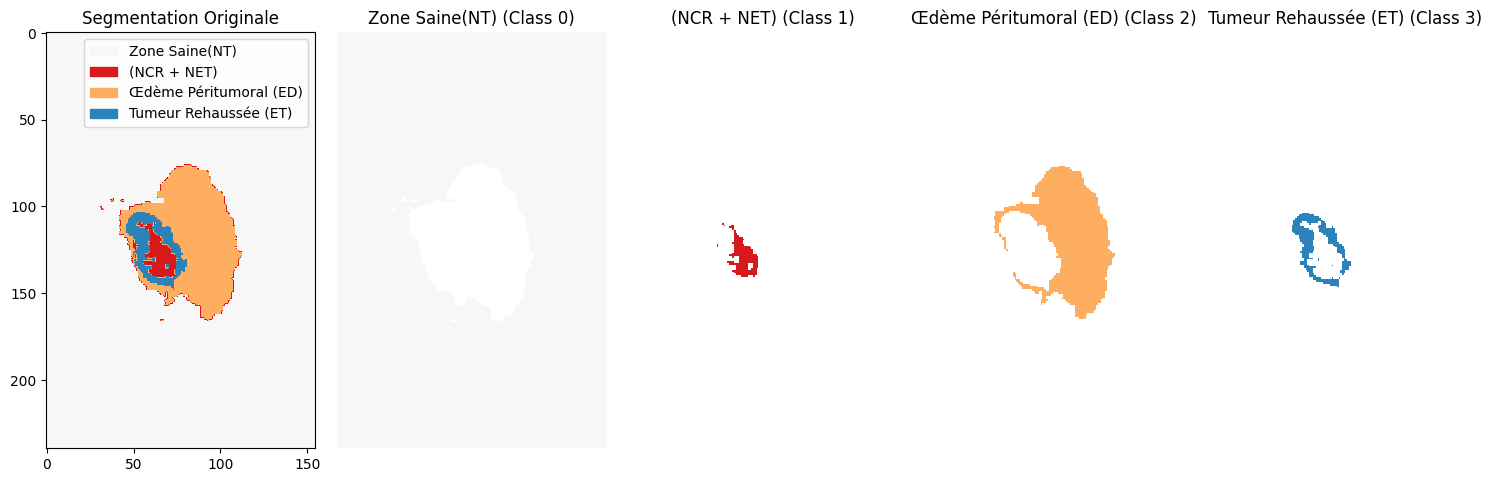

In [ ]:
class_names = [
    'Zone Saine(NT)',  # Class 0
    '(NCR + NET)',  # Class 1
    'Œdème Péritumoral (ED)',  # Class 2
    'Tumeur Rehaussée (ET)'  # Class 3 in legend for consistency
]
colors = ['#f7f7f7', '#d7191c', '#fdae61', '#2b83ba']
legend_items = [mpl.patches.Patch(color=colors[i], label=class_names[i]) for i in range(4)]
fig, axs = plt.subplots(1, 5, figsize=(15, 15))
modified_seg_img = some_seg_img.copy()
modified_seg_img[modified_seg_img == 4] = 3

class_values = [0, 1, 2, 3]

for i, class_val in enumerate(class_values):
    mask = np.where(modified_seg_img == class_val, class_val, np.nan)
    axs[i + 1].imshow(mask[100, :, :], cmap=cmap, norm=norm)  # Slice number is 100
    axs[i + 1].set_title(f'{class_names[class_val]} (Class {class_val})')
    axs[i + 1].axis('off')

axs[0].imshow(modified_seg_img[100, :, :], cmap=cmap, norm=norm)
axs[0].set_title('Segmentation Originale')
axs[0].legend(handles=legend_items, loc='upper right')

plt.tight_layout()
plt.show()


## Récapitulatif

Pour chaque échantillon ou patient, nous disposons de 4 modalités différentes (T1, T1CE, T2 et FLAIR), accompagnées d'une segmentation indiquant les zones de tumeur.

Les modalités T1CE et FLAIR sont particulièrement pertinentes, car elles fournissent des informations complémentaires sur l'anatomie et le contraste des tissus du cerveau du patient.

Chaque image est tridimensionnelle, ce qui permet son analyse à travers trois plans différents composés de coupes 2D.

De nombreuses coupes contiennent peu ou pas d'information.nous nous concentrerons uniquement sur l'intervalle de coupes (60:135).

 Une image de segmentation contient de 1 à 4 classes. Il est nécessaire de réattribuer la classe numéro 4 à la classe 3, car la valeur 3 est absente des données.
La classe 0 (fond) est surreprésentée dans la majorité des scans. Toutefois, une coupe excessive pourrait éliminer des informations importantes.


## Split de données


- **L'ensemble d'entraînement** est utilisé pour former le modèle. Pendant l'entraînement, le modèle ajuste ses paramètres pour minimiser l'erreur entre ses prédictions et la vérité terrain (les segmentations).

- **L'ensemble de validation** sert à affiner les hyperparamètres de notre modèle. Ces hyperparamètres, définis avant l'entraînement, déterminent le comportement du modèle. L'objectif est de comparer différentes configurations d'hyperparamètres et de sélectionner la meilleure pour notre modèle.

- **L'ensemble de test** est utilisé pour évaluer la performance de notre modèle après qu'il ait été entraîné, afin de voir comment il se comporte sur des données jamais vues auparavant.

Le jeu de données BraTS2020 est déjà divisé en deux dossiers : un dossier d'entraînement et un dossier de validation.
Malheureusement, le dossier de validation ne contient pas les données de segmentation et ne peut donc pas être utilisé. C'est pourquoi nous allons ignorer les échantillons de ce dossier et créer notre propre ensemble de validation.


In [ ]:
# Specify path of our BraTS2020 directory
data_path = "/content/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"

# Retrieve all samples from path with listdir(). This method lists of all files + directories in the specified directory.
samples = os.listdir(data_path)
print("Number of samples:", len(samples))

Number of samples: 371


In [ ]:
samples.remove("survival_info.csv")
samples.remove("name_mapping.csv")

In [ ]:
# Split the dataset into train and validation sets
samples_train, samples_val = train_test_split(samples, test_size=0.3, random_state=42)
samples_train, samples_test = train_test_split(samples_train, test_size=0.2, random_state=42)
print(f"Train length: {len(samples_train)}")
print(f"Validation length: {len(samples_val)}")
print(f"Test length: {len(samples_test)}")

Train length: 206
Validation length: 111
Test length: 52


# Préparation des données pour l'entraînement du réseau de neurones


Pour entraîner un réseau de neurones à segmenter des objets sur des images, il faut lui fournir à la fois les images brutes (X) et les segmentations de référence (y).
Cependant charger toutes ces images 3D surchargerait la mémoire et pourrait provoquer un plantage du système. Avant de les envoyer, nous devons donc les prétraiter en utilisant un Générateur de Données qui effectuera les opérations nécessaires lors du chargement des images.

Plus précisément, pour chaque échantillon, nous allons :
- Récupérer les chemins de ses modalités (T1CE & FLAIR), qui fournissent des informations complémentaires sur l'anatomie du cerveau.
- Charger les modalités et la segmentation.
- Créer un tableau X qui contiendra toutes les coupes sélectionnées (60-135) de ces deux modalités.
- Créer un tableau y qui contiendra toutes les coupes de la segmentation.
- Corriger les valeurs de segmentation, en assignant la valeur 3 aux données marquées avec 4.

En plus de ces étapes, nous effectuerons aussi :

- Le travail dans le plan axial : les images sont carrées (240x240), mais nous manipulerons une série de coupes.
- L'application d'un One-Hot Encoder sur le tableau y : convertir nos variables catégorielles (classes) en représentation numérique pour notre réseau de neurones.
- Le redimensionnement de chaque coupe d'image de (240x240) à (128x128) : cela est nécessaire car nos couches de pooling réduisent la résolution spatiale par 2, et nous avons besoin de dimensions qui sont des puissances de deux.

Ce choix de redimensionnement dépend de plusieurs facteurs, tels que la complexité du modèle, la quantité de données d'entraînement, les ressources computationnelles disponibles et le compromis souhaité entre efficacité computationnelle et préservation de l'information. Nous choisirons donc la forme (128x128) pour réduire la taille des paramètres du modèle et optimiser le temps d'entraînement et les exigences en mémoire.


In [ ]:
from tensorflow.keras.utils import Sequence
import numpy as np
import os
import nibabel as nib
import cv2
import tensorflow as tf

VOLUME_START_AT = 60
VOLUME_SLICES = 75
IMG_SIZE = 128

# DataGenerator prisde notebook de Rastislav, https://www.kaggle.com/code/rastislav/3d-mri-brain-tumor-segmentation-u-net
class DataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, dim=(IMG_SIZE,IMG_SIZE), batch_size = 1, n_channels = 2, shuffle=True):
        'Initialization'
        self.dim = dim # Resized image dimensions (128 x 128)
        self.batch_size = batch_size #  Number of images to load each time
        self.list_IDs = list_IDs # Patients IDs
        self.n_channels = n_channels # Number of channels (T1CE + FLAIR)
        self.shuffle = shuffle # Indicates if data is shuffled for each epoch
        self.on_epoch_end() # Updates indexes after each epoch

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        Batch_ids = [self.list_IDs[k] for k in indexes]

        # Load & Generate data
        X, y = self.__data_generation(Batch_ids)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, Batch_ids):
        'Generates data containing batch_size samples'
        # Initialization
        X = np.zeros((self.batch_size*VOLUME_SLICES, *self.dim, self.n_channels))
        y = np.zeros((self.batch_size*VOLUME_SLICES, 240, 240))

        # Generate data
        for c, i in enumerate(Batch_ids):

            # Get path of each RMI modality and the segmentation
            sample_path = os.path.join(data_path, i, i)
            t1ce_path = sample_path + '_t1ce.nii'
            flair_path = sample_path + '_flair.nii'
            seg_path = sample_path + '_seg.nii'
            if not os.path.exists(seg_path):
                continue


            # Extract the data from these paths
            t1ce = nib.load(t1ce_path).get_fdata()
            flair = nib.load(flair_path).get_fdata()
            seg = nib.load(seg_path).get_fdata()


            for j in range(VOLUME_SLICES):
                 X[j +VOLUME_SLICES*c,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
                 X[j +VOLUME_SLICES*c,:,:,1] = cv2.resize(t1ce[:,:,j+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))

                 y[j +VOLUME_SLICES*c] = seg[:,:,j+VOLUME_START_AT]

        y[y==4] = 3
        mask = tensorflow.one_hot(y, 4)
        Y = tensorflow.image.resize(mask, (IMG_SIZE, IMG_SIZE))
        max = np.max(X)
        if np.max(X) == 0:
            max = 1
        # Scale data between 0 and 1 (since the minimum value in the data is 0)
        return X/max, Y

training_generator = DataGenerator(samples_train)
valid_generator = DataGenerator(samples_val)
test_generator = DataGenerator(samples_test)


## Choix de l'architecture U-Net pour la segmentation

Le jeu de données BraTS2020 est composé d'images 3D, chacune constituée de multiples coupes 2D dans trois plans orthogonaux. Nous avons donc deux options : utiliser un U-Net 2D ou un U-Net 3D.

Théoriquement, un U-Net 3D serait plus adapté dans notre cas. Un tel modèle peut exploiter le contexte spatial tridimensionnel des images, ce qui aide à réduire les risques de faux positifs et de faux négatifs dus à des informations partielles ou incomplètes sur des coupes 2D individuelles.

Cependant, un U-Net 2D est plus rapide et nécessite moins de mémoire qu'un U-Net 3D, ce qui peut être un avantage significatif lorsqu'on travaille avec des ensembles de données volumineux ou des ressources de calcul limitées.

En pratique, il est souvent judicieux de tester les deux architectures, 2D et 3D, et de comparer leurs performances sur la tâche de segmentation spécifique.

## Exploration des architectures de segmentation

Nous aborderons la segmentation des images médicales avec trois architectures distinctes :

- **U-Net Basique** : Nous commencerons avec un U-Net classique, une architecture éprouvée et efficace pour de nombreuses tâches de segmentation 2D. Sa simplicité et sa rapidité nous permettront d'obtenir une ligne de base solide pour évaluer les performances.

- **Attention U-Net** : Ensuite, nous intégrerons un Attention U-Net, qui ajoute des mécanismes d'attention à l'architecture U-Net de base. Ces mécanismes permettent au modèle de se concentrer sur les parties les plus importantes de l'image, ce qui peut améliorer la précision de la segmentation en réduisant les erreurs dues aux informations bruitées ou non pertinentes.

- **Residual U-Net** : Enfin, nous expérimenterons avec un Residual U-Net, il s'agit d'une variante d'UNet qui intègre des connexions résiduelles dans l'architecture. Ces connexions résiduelles peuvent contribuer à atténuer le problème de disparition du gradient et à améliorer les performances globales du réseau.

## Évaluation et comparaison

Chacune de ces architectures sera évaluée pour déterminer laquelle offre le meilleur équilibre entre précision de segmentation, complexité computationnelle et temps d'entraînement. Cette comparaison nous permettra de sélectionner le modèle le plus adapté à nos besoins spécifiques en matière de segmentation de tumeurs cérébrales.

L'évaluation sera basée sur des métriques standardisées telles que la précision, le rappel et le score Dice, qui nous donneront une image claire de la performance de chaque modèle.

## Fonction de perte

Lors de l'entraînement d'un réseau de neurones convolutif (CNN), il est important de choisir une fonction de perte qui reflète précisément les performances du réseau. En effet, cette fonction permet de comparer les pixels prédits à ceux de la vérité terrain pour chaque patient. À chaque époque, l'objectif est de mettre à jour les poids de notre modèle de manière à minimiser cette fonction de perte et donc à améliorer la précision de ses prédictions.

Une fonction de perte couramment utilisée pour les problèmes de classification multi-classes est l'entropie croisée catégorielle, qui mesure la différence entre la distribution de probabilité prédite de chaque pixel et la valeur réelle de la vérité terrain encodée en one-hot. Il est à noter que les modèles de segmentation utilisent parfois aussi la fonction de perte de Dice. On utilise une combinaison de ces deux fonctions

## Fonction d'activation de sortie

Pour obtenir cette distribution de probabilité sur les différentes classes pour chaque pixel, nous appliquons une fonction d'activation softmax à la couche de sortie de notre réseau neuronal.

Cela signifie que pendant l'entraînement, notre CNN ajustera ses poids pour minimiser notre fonction de perte, qui compare les probabilités prédites données par la fonction softmax à celles de la segmentation de vérité terrain.

## Autres métriques

Il est également important de surveiller les performances du modèle en utilisant des métriques d'évaluation.

Nous utiliserons bien sûr l'exactitude (accuracy), qui est une mesure très populaire. Cependant, cette métrique peut être trompeuse lorsqu'on travaille avec des ensembles de données déséquilibrés comme BraTS2020, où la classe de fond est surreprésentée. Pour résoudre ce problème, nous utiliserons d'autres métriques telles que l'intersection sur l'union (IoU), le coefficient de Dice, la précision, la sensibilité et la spécificité.

- Exactitude : Mesure la proportion globale de pixels correctement classifiés, y compris les pixels positifs et négatifs.
- IoU : Mesure le chevauchement entre les segmentations prédites et la vérité terrain.
- Sensibilité (rappel ou taux de vrais positifs) : Mesure la proportion de pixels de vérité terrain positifs qui ont été correctement prédits comme positifs.
- Précision (valeur prédictive positive) : Mesure la proportion de pixels prédits positifs qui sont réellement positifs.
- Spécificité (taux de vrais négatifs) : Mesure la proportion de pixels de vérité terrain négatifs qui ont été correctement prédits comme négatifs.

In [ ]:
pip install tensorflow

In [ ]:
from tensorflow.keras.losses import binary_crossentropy

def dice_coeff(y_true, y_pred):
    smooth = 1.0  # smooth term to avoid division by zero
    y_true_f = tf.cast(tf.reshape(y_true, [-1]), tf.float32)
    y_pred_f = tf.cast(tf.reshape(y_pred, [-1]), tf.float32)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coeff(y_true, y_pred)

def dice_bce_loss(y_true, y_pred):
    dice_loss_value = dice_loss(y_true, y_pred)
    bce_loss_value = binary_crossentropy(y_true, y_pred)
    return dice_loss_value + bce_loss_value


def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

# U-net de base

In [ ]:

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, concatenate, BatchNormalization, Activation
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import backend as K


# U-Net implementation for BraTS 2019 by Naomi Fridman, https://naomi-fridman.medium.com/multi-class-image-segmentation-a5cc671e647a
def build_unet(inputs, ker_init, dropout):
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(inputs)
    conv1 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv1)

    pool = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool)
    conv = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv2)

    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv3)

    pool4 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(pool4)
    conv5 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv5)
    drop5 = Dropout(dropout)(conv5)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = 2)(drop5))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = 2)(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = 2)(conv8))
    merge9 = concatenate([conv,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv9)

    up = Conv2D(32, 2, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(UpSampling2D(size = 2)(conv9))
    merge = concatenate([conv1,up], axis = 3)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(merge)
    conv = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = ker_init)(conv)

    conv10 = Conv2D(4, 1, activation = 'softmax')(conv)

    return Model(inputs = inputs, outputs = conv10)

input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

# Build and compile the model
unet_model = build_unet(input_layer, 'he_normal', 0.2)

unet_model.compile(optimizer='adam', loss=dice_bce_loss, metrics=['accuracy', dice_coeff, precision, sensitivity, tensorflow.keras.metrics.MeanIoU(num_classes=4)])


early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)

num_samples = len(samples_train)
batch_size = 64
steps_per_epoch = int(np.ceil(num_samples / batch_size))
# Calculate new steps per epoch


In [ ]:
unet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 2)]        0         []                            
                                                                                                  
 conv2d_23 (Conv2D)          (None, 128, 128, 32)         608       ['input_2[0][0]']             
                                                                                                  
 conv2d_24 (Conv2D)          (None, 128, 128, 32)         9248      ['conv2d_23[0][0]']           
                                                                                                  
 max_pooling2d_4 (MaxPoolin  (None, 64, 64, 32)           0         ['conv2d_24[0][0]']           
 g2D)                                                                                       

In [ ]:
import gc
gc.collect()

152

In [ ]:
import time
start_time = time.time()
history = unet_model.fit(
    training_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    epochs=50,
    callbacks=[reduce_lr],
      # Set the batch size to 32
)

end_time = time.time()
elapsed_time = end_time - start_time
print(f'{elapsed_time:.01f}s')


Epoch 1/50
4/4 [==============================] - 60s 14s/step - loss: 1.5989 - accuracy: 0.7758 - dice_coeff: 0.4537 - precision: 0.3691 - sensitivity: 0.2361 - mean_io_u_1: 0.4238 - val_loss: 1.1393 - val_accuracy: 0.9793 - val_dice_coeff: 0.4150 - val_precision: 0.9243 - val_sensitivity: 0.2617 - val_mean_io_u_1: 0.3757 - lr: 0.0010
Epoch 2/50
4/4 [==============================] - 41s 13s/step - loss: 0.7407 - accuracy: 0.9843 - dice_coeff: 0.7880 - precision: 0.9699 - sensitivity: 0.7637 - mean_io_u_1: 0.6041 - val_loss: 0.5477 - val_accuracy: 0.9793 - val_dice_coeff: 0.9733 - val_precision: 0.9793 - val_sensitivity: 0.9777 - val_mean_io_u_1: 0.8321 - lr: 0.0010
Epoch 3/50
4/4 [==============================] - 40s 13s/step - loss: 0.3413 - accuracy: 0.9875 - dice_coeff: 0.9217 - precision: 0.9873 - sensitivity: 0.9673 - mean_io_u_1: 0.5185 - val_loss: 0.2070 - val_accuracy: 0.9793 - val_dice_coeff: 0.9443 - val_precision: 0.9792 - val_sensitivity: 0.9713 - val_mean_io_u_1: 0.3761

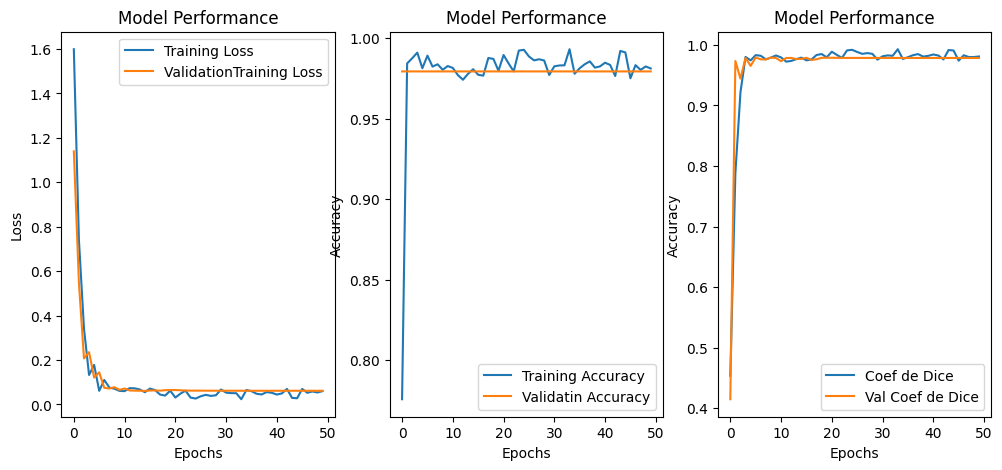

In [ ]:
# Plotting training results
import matplotlib.pyplot as plt

def plot_history(history, title="Model Performance"):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='ValidationTraining Loss')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validatin Accuracy')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(history.history['dice_coeff'], label='Coef de Dice')
    plt.plot(history.history['val_dice_coeff'], label='Val Coef de Dice')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

plot_history(history)
plt.show()

In [ ]:
def predict_segmentation(sample_path, model):
    # Load NIfTI (.nii) files of the sample (patient)
    t1ce_path = sample_path + '_t1ce.nii'
    flair_path = sample_path + '_flair.nii'
    #t1_path = sample_path + '_t1.nii'
    #t2_path = sample_path + '_t2.nii'

    # Extract the data from these paths
    t1ce = nib.load(t1ce_path).get_fdata()
    flair = nib.load(flair_path).get_fdata()

    # Create an empty array
    X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))

    # Perform the same operations as our DataGenerator, to keep the same input shape
    for j in range(VOLUME_SLICES):
        X[j,:,:,0] = cv2.resize(flair[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))
        X[j,:,:,1] = cv2.resize(t1ce[:,:,j+VOLUME_START_AT], (IMG_SIZE,IMG_SIZE))

    return model.predict(X/np.max(X))

In [ ]:
predictions = unet_model.predict(test_generator)

52/52 [==============================] - 22s 416ms/step


In [ ]:
predictions.shape

(3900, 128, 128, 4)

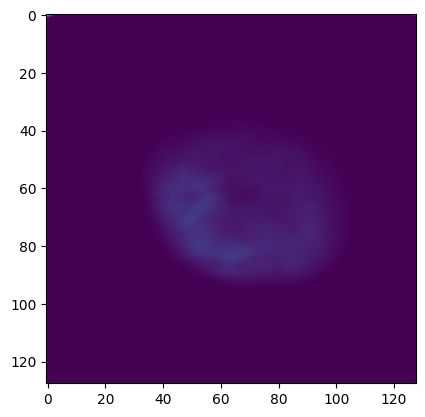

In [ ]:
plt.imshow(predictions[10,:,:,3])

In [ ]:
def show_predicted_segmentations(samples_list, slice_to_plot, cmap, norm, model):
    # Choose a random patient
    random_sample = random.choice(samples_list)

    # Get path of this patient
    random_sample_path = os.path.join(data_path, random_sample, random_sample)

    # Predict patient's segmentation
    predicted_seg = predict_segmentation(random_sample_path, model)

    # Load patient's original segmentation (Ground truth)
    seg_path = random_sample_path + '_seg.nii'
    seg = nib.load(seg_path).get_fdata()

    # Resize original segmentation to the same dimensions of the predictions. (Add VOLUME_START_AT because original segmentation contains 155 slices vs only 75 for our prediction)
    seg=cv2.resize(seg[:,:,slice_to_plot+VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_NEAREST)

    # Differentiate segmentations by their labels
    all = predicted_seg[slice_to_plot,:,:,1:4] # Deletion of class 0 (Keep only Core + Edema + Enhancing classes)
    zero = predicted_seg[slice_to_plot,:,:,0] # Isolation of class 0, Background (kind of useless, it is the opposite of the "all")
    first = predicted_seg[slice_to_plot,:,:,1] # Isolation of class 1, Core
    second = predicted_seg[slice_to_plot,:,:,2] # Isolation of class 2, Edema
    third = predicted_seg[slice_to_plot,:,:,3] # Isolation of class 3, Enhancing

    # Plot Original segmentation & predicted segmentation
    print("Patient number: ", random_sample)
    fig, axstest = plt.subplots(1, 6, figsize=(25, 20))

    # Original segmentation
    axstest[0].imshow(seg, cmap, norm)
    axstest[0].set_title('Original Segmentation')

    # Layers 1, 2, 3
    axstest[1].imshow(all)
    axstest[1].set_title('Predicted Segmentation - all layers')

    # Layer 0
    axstest[2].imshow(zero)
    axstest[2].set_title('Predicted Segmentation - layer 0')

    # Layer 1
    axstest[3].imshow(first)
    axstest[3].set_title('Predicted Segmentation - layer 1')

    # Layer 2
    axstest[4].imshow(second)
    axstest[4].set_title('Predicted Segmentation - layer 2')

    # Layer 3
    axstest[5].imshow(third)
    axstest[5].set_title('Predicted Segmentation - layer 3')

    # Add space between subplots
    plt.subplots_adjust(wspace=0.8)

    plt.show()

3/3 [==============================] - 0s 71ms/step
Patient number:  BraTS20_Training_121


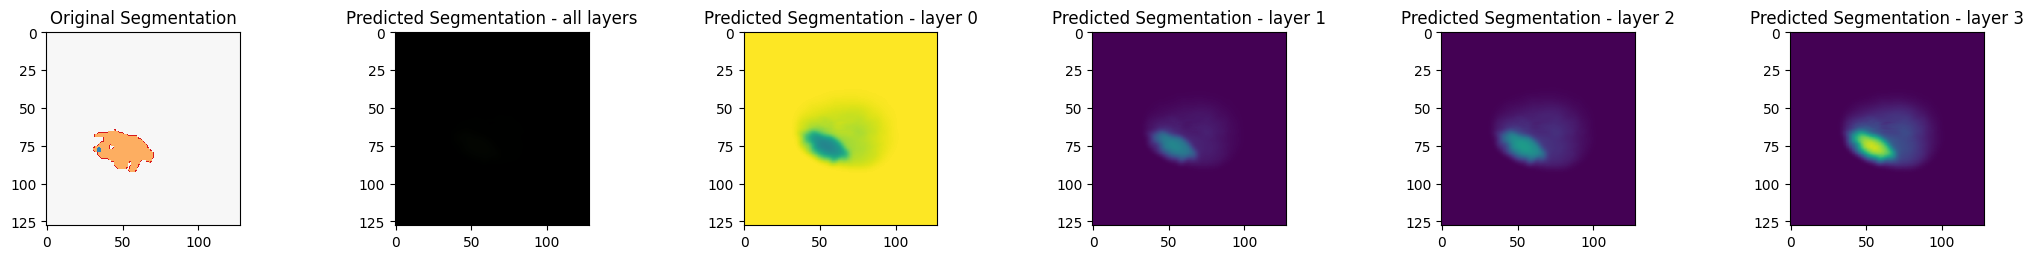

In [ ]:
show_predicted_segmentations(samples_test, 40, cmap, norm, unet_model)

On remarque qu 'on a de faux positifs


In [ ]:
import os

data_path = "brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"
expected_files = [f"BraTS20_Training_{i:03d}/BraTS20_Training_{i:03d}_seg.nii" for i in range(1, 370)]  # Adjust range as necessary

missing_files = [file for file in expected_files if not os.path.exists(os.path.join(data_path, file))]
print("Missing files:", missing_files)


Missing files: ['BraTS20_Training_355/BraTS20_Training_355_seg.nii']


In [ ]:
import gc
gc.collect()

18606

In [ ]:
try:
    test_loss, test_accuracy, test_dice, test_precision, test_sensitivity, test_mean_iou = unet_model.evaluate(test_generator)
    print(f'Test Loss: {test_loss}')
    print(f'Test Accuracy: {test_accuracy}')
    print(f'Test Dice Coefficient: {test_dice}')
    print(f'Test Precision: {test_precision}')
    print(f'Test Sensitivity: {test_sensitivity}')
    print(f'Test Mean IoU: {test_mean_iou}')
except Exception as e:
    print(f"Error during evaluation: {e}")

52/52 [==============================] - 21s 391ms/step - loss: 0.0540 - accuracy: 0.9817 - dice_coeff: 0.9806 - precision: 0.9817 - sensitivity: 0.9817 - mean_io_u_1: 0.8201
Test Loss: 0.05398901179432869
Test Accuracy: 0.9817292094230652
Test Dice Coefficient: 0.9806219339370728
Test Precision: 0.9817230701446533
Test Sensitivity: 0.981748640537262
Test Mean IoU: 0.8200644850730896


# Résidual U-net

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout, Add, Activation, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import backend as K

def residual_block(x, filters, kernel_size=3):
    shortcut = Conv2D(filters, (1, 1), padding='same')(x)  # Adjust shortcut to match dimensions
    x = Conv2D(filters, kernel_size, padding='same', activation=None)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, kernel_size, padding='same', activation=None)(x)
    x = BatchNormalization()(x)
    x = Add()([shortcut, x])
    x = Activation('relu')(x)
    return x

def build_residual_unet(inputs, ker_init, dropout):
    conv1 = residual_block(inputs, 32)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = residual_block(pool1, 64)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = residual_block(pool2, 128)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = residual_block(pool3, 256)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = residual_block(pool4, 512)
    drop5 = Dropout(dropout)(conv5)

    up6 = UpSampling2D(size=(2, 2))(drop5)
    merge6 = concatenate([conv4, up6], axis=3)
    conv6 = residual_block(merge6, 256)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = residual_block(merge7, 128)

    up8 = UpSampling2D(size=(2, 2))(conv7)
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = residual_block(merge8, 64)

    up9 = UpSampling2D(size=(2, 2))(conv8)
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = residual_block(merge9, 32)

    conv10 = Conv2D(4, 1, activation='softmax')(conv9)

    return Model(inputs=inputs, outputs=conv10)

input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

# Build and compile the Residual U-Net model
residual_unet_model = build_residual_unet(input_layer, 'he_normal', 0.2)

residual_unet_model.compile(optimizer='adam', loss=dice_bce_loss, metrics=['accuracy', dice_coeff, precision, sensitivity, tf.keras.metrics.MeanIoU(num_classes=4)])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)

num_samples = len(samples_train)
batch_size = 64  # Adjust batch size if needed

# Calculate new steps per epoch
steps_per_epoch = int(np.ceil(num_samples / batch_size))
residual_unet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 2)]        0         []                            
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 32)         608       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 32)         128       ['conv2d_1[0][0]']            
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 128, 128, 32)         0         ['batch_normalization[0][0

In [ ]:
import gc
gc.collect()

32237

In [ ]:
import time
start_time = time.time()
try:
    history = residual_unet_model.fit(
        training_generator,
        steps_per_epoch=steps_per_epoch,
        validation_data=valid_generator,
        epochs=50,
        callbacks=[reduce_lr],
        verbose=1
    )
except Exception as e:
    print(f"Error during training: {e}")
end_time = time.time()
elapsed_time = end_time - start_time
print(f'{elapsed_time:.01f}s')

Epoch 1/50
4/4 [==============================] - 65s 8s/step - loss: 0.9696 - accuracy: 0.6896 - dice_coeff: 0.5954 - precision: 0.6960 - sensitivity: 0.6308 - mean_io_u: 0.3756 - val_loss: 2.1181 - val_accuracy: 0.2848 - val_dice_coeff: 0.1717 - val_precision: 0.0215 - val_sensitivity: 0.0123 - val_mean_io_u: 0.3742 - lr: 0.0010
Epoch 2/50
4/4 [==============================] - 21s 7s/step - loss: 0.1457 - accuracy: 0.9787 - dice_coeff: 0.9744 - precision: 0.9787 - sensitivity: 0.9787 - mean_io_u: 0.3761 - val_loss: 2.2041 - val_accuracy: 0.4999 - val_dice_coeff: 0.2455 - val_precision: 0.0392 - val_sensitivity: 0.0117 - val_mean_io_u: 0.3719 - lr: 0.0010
Epoch 3/50
4/4 [==============================] - 20s 7s/step - loss: 0.0743 - accuracy: 0.9803 - dice_coeff: 0.9778 - precision: 0.9802 - sensitivity: 0.9802 - mean_io_u: 0.3812 - val_loss: 1.3611 - val_accuracy: 0.6510 - val_dice_coeff: 0.3749 - val_precision: 0.4631 - val_sensitivity: 0.1557 - val_mean_io_u: 0.3756 - lr: 0.0010
E

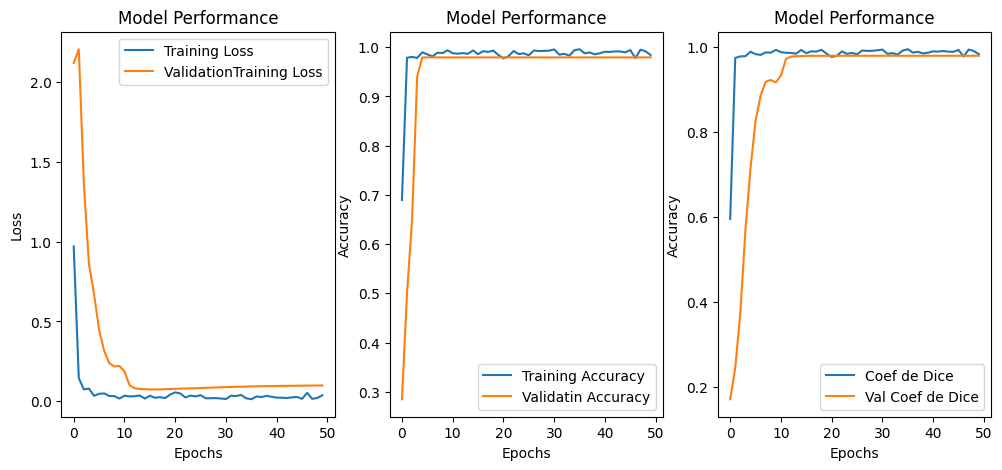

In [ ]:
# Plotting training results
import matplotlib.pyplot as plt

def plot_history(history, title="Model Performance"):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='ValidationTraining Loss')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validatin Accuracy')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(history.history['dice_coeff'], label='Coef de Dice')
    plt.plot(history.history['val_dice_coeff'], label='Val Coef de Dice')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

plot_history(history)
plt.show()

In [ ]:
predictions = residual_unet_model.predict(test_generator)

52/52 [==============================] - 13s 252ms/step


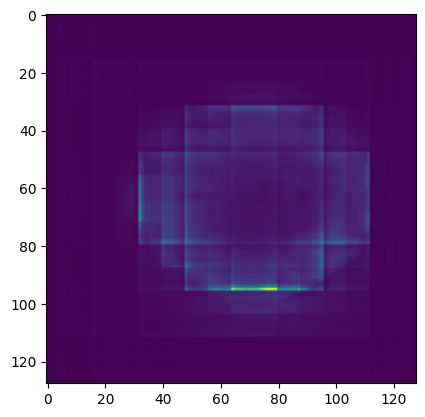

In [ ]:
predictions.shape
plt.imshow(predictions[3,:,:,3])

3/3 [==============================] - 0s 35ms/step
Patient number:  BraTS20_Training_133


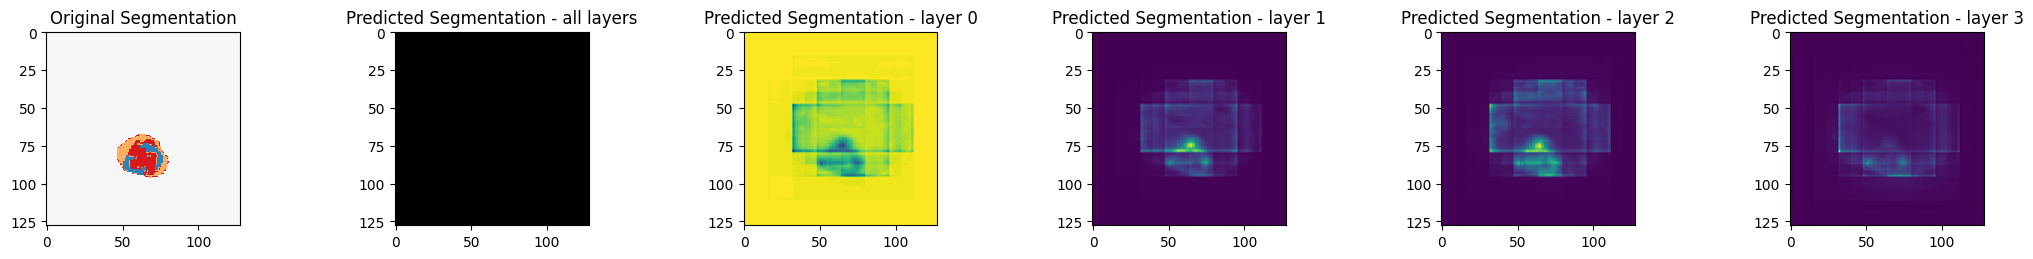

In [ ]:
show_predicted_segmentations(samples_test, 20, cmap, norm, residual_unet_model)

In [ ]:
 # Evaluate the model on the test data
try:
    test_loss, test_accuracy, test_dice, test_precision, test_sensitivity, test_mean_iou = residual_unet_model.evaluate(test_generator)
    print(f'Test Loss: {test_loss}')
    print(f'Test Accuracy: {test_accuracy}')
    print(f'Test Dice Coefficient: {test_dice}')
    print(f'Test Precision: {test_precision}')
    print(f'Test Sensitivity: {test_sensitivity}')
    print(f'Test Mean IoU: {test_mean_iou}')
except Exception as e:
    print(f"Error during evaluation: {e}")

52/52 [==============================] - 9s 172ms/step - loss: 0.0897 - accuracy: 0.9817 - dice_coeff: 0.9817 - precision: 0.9817 - sensitivity: 0.9818 - mean_io_u: 0.7866
Test Loss: 0.08966869860887527
Test Accuracy: 0.9817291498184204
Test Dice Coefficient: 0.9817198514938354
Test Precision: 0.9817247986793518
Test Sensitivity: 0.9817501902580261
Test Mean IoU: 0.7866137027740479


# Attention U-net


In [ ]:
pip install tensorflow

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout, Activation, Add, Multiply
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import backend as K

def attention_block(x, g, inter_channel):
    theta_x = Conv2D(inter_channel, (1, 1), strides=(1, 1))(x)
    phi_g = Conv2D(inter_channel, (1, 1), strides=(1, 1))(g)
    add_xg = Add()([theta_x, phi_g])
    act_xg = Activation('relu')(add_xg)
    psi = Conv2D(1, (1, 1), strides=(1, 1))(act_xg)
    sigmoid_xg = Activation('sigmoid')(psi)
    mul_xg = Multiply()([x, sigmoid_xg])
    return mul_xg

def build_attention_unet(inputs, ker_init, dropout):
    conv1 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(inputs)
    conv1 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool1)
    conv2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool2)
    conv3 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool3)
    conv4 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool4)
    conv5 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv5)
    drop5 = Dropout(dropout)(conv5)

    up6 = UpSampling2D(size=(2, 2))(drop5)
    attn6 = attention_block(conv4, up6, 256)
    merge6 = concatenate([attn6, up6], axis=3)
    conv6 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init)(merge6)
    conv6 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv6)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    attn7 = attention_block(conv3, up7, 128)
    merge7 = concatenate([attn7, up7], axis=3)
    conv7 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init)(merge7)
    conv7 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv7)

    up8 = UpSampling2D(size=(2, 2))(conv7)
    attn8 = attention_block(conv2, up8, 64)
    merge8 = concatenate([attn8, up8], axis=3)
    conv8 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(merge8)
    conv8 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv8)

    up9 = UpSampling2D(size=(2, 2))(conv8)
    attn9 = attention_block(conv1, up9, 32)
    merge9 = concatenate([attn9, up9], axis=3)
    conv9 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(merge9)
    conv9 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv9)

    conv10 = Conv2D(4, 1, activation='softmax')(conv9)

    return Model(inputs=inputs, outputs=conv10)

input_layer = Input((IMG_SIZE, IMG_SIZE, 2))

# Build and compile the model
attention_unet_model = build_attention_unet(input_layer, 'he_normal', 0.2)

attention_unet_model.compile(optimizer='adam', loss=dice_bce_loss, metrics=['accuracy', dice_coeff, precision, sensitivity, tf.keras.metrics.MeanIoU(num_classes=4)])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)

num_samples = len(samples_train)
batch_size = 64

# Calculate new steps per epoch
steps_per_epoch = int(np.ceil(num_samples / batch_size))

attention_unet_model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 2)]        0         []                            
                                                                                                  
 conv2d_28 (Conv2D)          (None, 128, 128, 32)         608       ['input_2[0][0]']             
                                                                                                  
 conv2d_29 (Conv2D)          (None, 128, 128, 32)         9248      ['conv2d_28[0][0]']           
                                                                                                  
 max_pooling2d_4 (MaxPoolin  (None, 64, 64, 32)           0         ['conv2d_29[0][0]']           
 g2D)                                                                                       

In [ ]:
 import gc
gc.collect()

34355

In [ ]:
import time
start_time = time.time()
try:
    history = attention_unet_model.fit(
        training_generator,
        validation_data=valid_generator,
        epochs=50,
        steps_per_epoch=steps_per_epoch,
        validation_steps=int(np.ceil(len(samples_val) / batch_size)),
        callbacks=[reduce_lr],
        verbose=1  # Add verbose to see detailed training logs
    )
except Exception as e:
    print(f"Error during training: {e}")
end_time = time.time()
elapsed_time = end_time - start_time
print(f'{elapsed_time:.01f}s')

Epoch 1/50
4/4 [==============================] - 2s 580ms/step - loss: 0.0475 - accuracy: 0.9856 - dice_coeff: 0.9834 - precision: 0.9856 - sensitivity: 0.9856 - mean_io_u_1: 0.7302 - val_loss: 0.0960 - val_accuracy: 0.9705 - val_dice_coeff: 0.9687 - val_precision: 0.9705 - val_sensitivity: 0.9705 - val_mean_io_u_1: 0.7405 - lr: 1.8190e-15
Epoch 2/50
4/4 [==============================] - 2s 517ms/step - loss: 0.0983 - accuracy: 0.9667 - dice_coeff: 0.9653 - precision: 0.9667 - sensitivity: 0.9668 - mean_io_u_1: 0.7481 - val_loss: 0.0519 - val_accuracy: 0.9839 - val_dice_coeff: 0.9826 - val_precision: 0.9839 - val_sensitivity: 0.9839 - val_mean_io_u_1: 0.7567 - lr: 1.8190e-15
Epoch 3/50
4/4 [==============================] - 2s 523ms/step - loss: 0.0588 - accuracy: 0.9809 - dice_coeff: 0.9790 - precision: 0.9808 - sensitivity: 0.9809 - mean_io_u_1: 0.7243 - val_loss: 0.0474 - val_accuracy: 0.9836 - val_dice_coeff: 0.9825 - val_precision: 0.9836 - val_sensitivity: 0.9836 - val_mean_io_

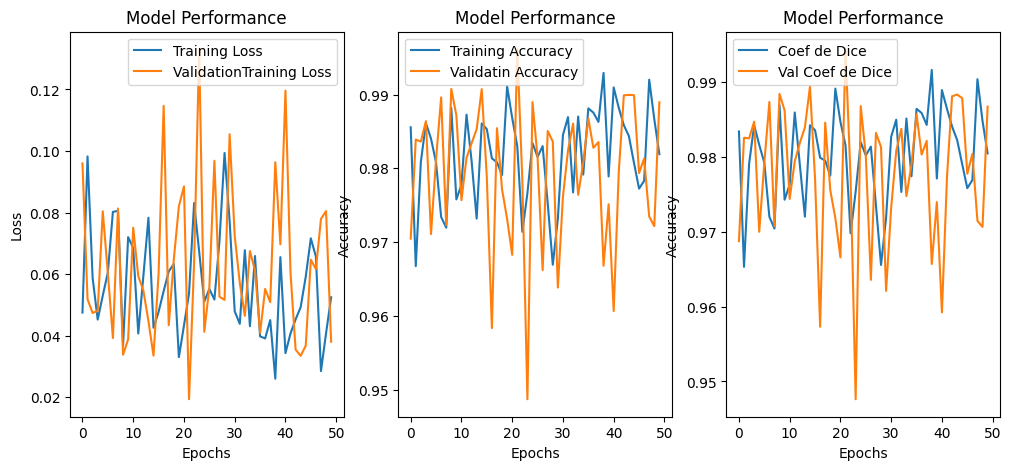

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history, title="Model Performance"):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='ValidationTraining Loss')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validatin Accuracy')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(history.history['dice_coeff'], label='Coef de Dice')
    plt.plot(history.history['val_dice_coeff'], label='Val Coef de Dice')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

plot_history(history)
plt.show()

2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 835ms/stepWARNING:tensorflow:5 out of the last 58 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x7f772f710b80> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 649ms/step
Patient number:  BraTS20_Training_294


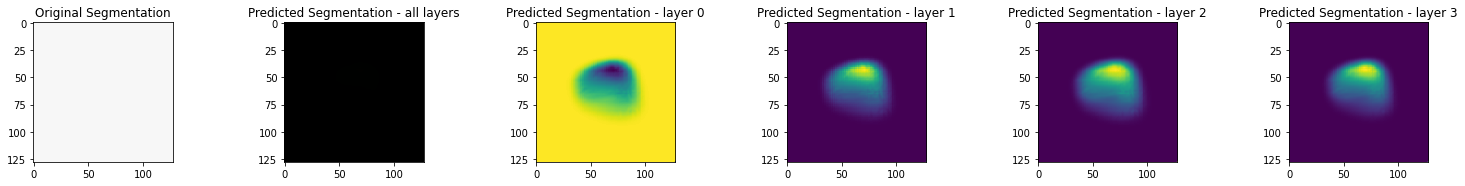

In [ ]:
show_predicted_segmentations(samples_test, 40, cmap, norm, attention_unet_model)

In [ ]:
 try:
    test_loss, test_accuracy, test_dice, test_precision, test_sensitivity, test_mean_iou = attention_unet_model.evaluate(test_generator)
    print(f'Test Loss: {test_loss}')
    print(f'Test Accuracy: {test_accuracy}')
    print(f'Test Dice Coefficient: {test_dice}')
    print(f'Test Precision: {test_precision}')
    print(f'Test Sensitivity: {test_sensitivity}')
    print(f'Test Mean IoU: {test_mean_iou}')
except Exception as e:
    print(f"Error during evaluation: {e}")

52/52 [==============================] - 9s 171ms/step - loss: 0.0563 - accuracy: 0.9817 - dice_coeff: 0.9800 - precision: 0.9817 - sensitivity: 0.9817 - mean_io_u_1: 0.7437
Test Loss: 0.056304171681404114
Test Accuracy: 0.9817290902137756
Test Dice Coefficient: 0.9800339341163635
Test Precision: 0.9817244410514832
Test Sensitivity: 0.9817498922348022
Test Mean IoU: 0.7437238693237305
